# Step 1 (a): Installing dependencies

In [ ]:
!pip install torch torchvision matplotlib tqdm opencv-python-headless imutils kagglehub

# Step 1 (b): Load and Explore the Dataset.

In [ ]:
import kagglehub

dataset_slug = "masoudnickparvar/brain-tumor-mri-dataset"

path = kagglehub.dataset_download(dataset_slug)
print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:01<00:00, 138MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


# Step 2.1: Data Preprocessing
### Preprocessing code, as referenced from:
https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

In [ ]:
import cv2
import os
import numpy as np
import imutils

IMG_SIZE = 256

def crop_img(img):
    """
    Crop the image to remove extra margins.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    return new_img

def preprocess_images(input_dir, output_dir, img_size=IMG_SIZE):
    """
    Preprocess the images: Crop and Resize them.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for class_folder in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_folder)
        save_path = os.path.join(output_dir, class_folder)

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)

            # Crop and resize
            img = crop_img(img)
            img = cv2.resize(img, (img_size, img_size))

            cv2.imwrite(os.path.join(save_path, img_name), img)

# Example usage (adjust the paths as needed)
train_dir = f"{path}/Training"
test_dir = f"{path}/Testing"
output_train_dir = "/content/processed/Training"
output_test_dir = "/content/processed/Testing"

preprocess_images(train_dir, output_train_dir)
preprocess_images(test_dir, output_test_dir)


# Step 2.2 Data Augmentation

In [ ]:
from torchvision import transforms

# Define augmentations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}


# Step 2.3 Normalize the Data


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        normalize,
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ]),
}

train_dir = '/content/processed/Training'
val_dir = '/content/processed/Testing'

train_dataset = ImageFolder(root=train_dir, transform=data_transforms['train'])
val_dataset = ImageFolder(root=val_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training data: {len(train_loader.dataset)} images")
print(f"Validation data: {len(val_loader.dataset)} images")


Training data: 5712 images
Validation data: 1311 images


# Step 3: Building the Model
## 3.1 Model Setup Using ResNet18

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

model = models.resnet18(pretrained=True)

num_classes = 4  # glioma, meningioma, no tumor, pituitary
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 3.2 Set Up Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


## 3.3 Training the Model
#### Skip to 3.4 to load a model instead

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        running_loss += loss.item()

    # Calculating the average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct_predictions / total_predictions

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

print("\nTraining finished.")


Epoch [1/25], Loss: 0.3891, Accuracy: 86.33%
Epoch [2/25], Loss: 0.2046, Accuracy: 93.03%
Epoch [3/25], Loss: 0.1913, Accuracy: 93.54%
Epoch [4/25], Loss: 0.1252, Accuracy: 95.78%
Epoch [5/25], Loss: 0.1351, Accuracy: 95.19%
Epoch [6/25], Loss: 0.1069, Accuracy: 96.34%
Epoch [7/25], Loss: 0.0972, Accuracy: 96.76%
Epoch [8/25], Loss: 0.0897, Accuracy: 97.09%
Epoch [9/25], Loss: 0.0813, Accuracy: 97.15%
Epoch [10/25], Loss: 0.0723, Accuracy: 97.69%
Epoch [11/25], Loss: 0.0653, Accuracy: 98.06%
Epoch [12/25], Loss: 0.0923, Accuracy: 96.99%
Epoch [13/25], Loss: 0.0564, Accuracy: 98.25%
Epoch [14/25], Loss: 0.0500, Accuracy: 98.25%
Epoch [15/25], Loss: 0.0521, Accuracy: 98.49%
Epoch [16/25], Loss: 0.0612, Accuracy: 98.14%
Epoch [17/25], Loss: 0.0393, Accuracy: 98.84%
Epoch [18/25], Loss: 0.0559, Accuracy: 98.28%
Epoch [19/25], Loss: 0.0394, Accuracy: 98.62%
Epoch [20/25], Loss: 0.0426, Accuracy: 98.69%
Epoch [21/25], Loss: 0.0508, Accuracy: 98.35%
Epoch [22/25], Loss: 0.0420, Accuracy: 98.8

## [Optional] Step 3.3.1: Save the Model
#### We skip this step and go to 3.4 if we didn't train any model and wish to load one instead.

In [ ]:
# Save the trained model
model_path = "brain_tumor_detection_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to brain_tumor_detection_model.pth


<a name="34-loading-the-model"></a>
## 3.4 Load a model
#### Skip this step if you trained a model in 3.3

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
import gdown

model_url = 'https://drive.google.com/uc?export=download&id=1Ek3vCjMQ71vzdUAesHY3Mk_B5XIMP1eQ'

output_path = 'model.pth'
gdown.download(model_url, output_path, quiet=False)

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load(output_path, map_location=device))

model = model.to(device)

model.eval()

print("Model loaded successfully!")


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1Ek3vCjMQ71vzdUAesHY3Mk_B5XIMP1eQ
From (redirected): https://drive.google.com/uc?export=download&id=1Ek3vCjMQ71vzdUAesHY3Mk_B5XIMP1eQ&confirm=t&uuid=7da8c8fc-dbba-4a71-9a70-8ea990ed6380
To: /content/model.pth
100%|██████████| 44.8M/44.8M [00:00<00:00, 199MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


<ipython-input-16-f5ae4da0278a>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(output_path, map_location=device))


## 3.5 Validation

In [ ]:
# Validation loop
model.eval()
val_loss = 0.0
val_correct_predictions = 0
val_total_predictions = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        val_correct_predictions += (predicted == labels).sum().item()
        val_total_predictions += labels.size(0)

        val_loss += loss.item()

# Calculate average validation loss and accuracy
val_loss /= len(val_loader)
val_accuracy = 100 * val_correct_predictions / val_total_predictions

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Validation Loss: 0.0313, Validation Accuracy: 99.24%


# Step 4: Inference (Predict Tumor Type for New Images)

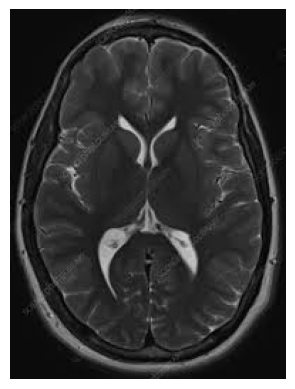

Predicted Class: no tumor


In [ ]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def predict_and_display_image(image_url):
    try:
        # Download the image from the URL
        response = requests.get(image_url)
        response.raise_for_status()

        img = Image.open(BytesIO(response.content))

        # Convert to grayscale
        img = img.convert('L')
        img = ImageOps.grayscale(img)

        # Convert grayscale image to 3 channels (RGB)
        img = Image.merge("RGB", (img, img, img))

        # Display the image
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        img = img.resize((256, 256))


        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        img_tensor = transform(img).unsqueeze(0)
        img_tensor = img_tensor.to(device)

        # Make prediction
        with torch.no_grad():
            outputs = model(img_tensor)
            _, predicted = torch.max(outputs, 1)

        class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']
        predicted_class_name = class_names[predicted.item()]

        return predicted_class_name

    except requests.exceptions.RequestException as e:
        print(f"Error downloading the image: {e}")
        return None
    except Exception as e:
        print(f"Error processing the image: {e}")
        return None

# Example usage with an image URL
# image_url = "https://miro.medium.com/v2/resize:fit:512/1*R-UqkRaw1WtlQRrGMcACwA.jpeg"  # Glioma
# image_url = "https://prod-images-static.radiopaedia.org/images/8337017/dd86e8296503e5713851c6908df2bd_big_gallery.jpg"  # Meningioma
# image_url = "https://images.squarespace-cdn.com/content/v1/5c78644eab1a6242150c8862/1597982644923-MJHRUK1CBQYMYBSBRXBL/Pituitary%2BTumor%2BLabelled.jpg"  # Pituitory
image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSgFN9JbZaMQRwEZp5FqJsbAEV1LaMqNJPZ5A&s"  # No tumor


predicted_class = predict_and_display_image(image_url)
if predicted_class:
    print(f"Predicted Class: {predicted_class}")
